In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas.io.sql as pd_sql
import pickle
from collections import OrderedDict, Counter
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate
from xgboost import XGBClassifier
from sklearn import svm, naive_bayes, neighbors, ensemble
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.datasets import make_classification

Using TensorFlow backend.


In [2]:
health_options = ['With health insurance coverage', 'No health insurance coverage']

In [3]:
df = pd.read_csv('healthcare.csv')

In [4]:
# STATEFIP used so PWSTATE not needed; 2017 so YEAR not needed
df = df.drop(['PWSTATE2', 'YEAR', 'DATANUM', 'SERIAL', 'CBSERIAL', 'HHWT', 'DIVINYR',
              'GQ', 'PERNUM', 'EDUCD', 'RACED', 'EMPSTATD', 'INCTOT', 'VETSTATD'], axis=1)

In [5]:
df.columns = df.columns.str.lower()

In [6]:
# Change hcovany: 0: has health insurance, 1: no health insurance
df['hcovany'] = df['hcovany'].replace([2], [0])

In [7]:
# 0-N/A 1-No 2-Yes
round(df['perwt'][(df['diffcare'] == 2) & (df['hcovany'] == 1)].sum() / df['perwt'][(df['diffcare'] == 2) & (df['hcovany'] == 0)].sum(), 2)

0.03

In [8]:
# People who have difficulty caring for themselves have health insurance so drop feature:
df = df.drop(['diffcare'], axis=1)

In [9]:
#0-N/A 1-No vision or hearing difficulty 2-Has vision or hearing difficulty
round(df['perwt'][(df['diffsens'] == 1) & (df['hcovany'] == 1)].sum() / df['perwt'][(df['diffsens'] == 1) & (df['hcovany'] == 0)].sum(), 2)

0.1

In [10]:
# People who have vision/hearing difficulties have almost the same rate of health insurance so drop feature:
df = df.drop(['diffsens'], axis=1)

In [11]:
#0-N/A 1-Not a veteran 2-Veteran 9-Unknown
round(df['perwt'][(df['vetstat'] == 2) & (df['hcovany'] == 1)].sum() / df['perwt'][(df['vetstat'] == 2) & (df['hcovany'] == 0)].sum(), 2)

0.03

In [12]:
# People who are veterans have health insurance so drop feature:
df = df.drop(['vetstat'], axis=1)

In [13]:
#temp drop
df = df.drop(['countyfip', 'city', 'hcovpriv', 'hcovpub'], axis=1)

**perwt**  
perwt is a 6-digit numeric variable which indicates how many persons in the U.S. population are represented by a given person in an IPUMS sample and has two implied decimals.

**SEX**  
1-Male:2-Female  

**MARST** (Marital Status)  
1-Married, spouse present
2-Married, spouse absent
3-Separated
4-Divorced
5-Widowed
6-Never married/single

**DIVINYR** (Divorced in the past year)  
0-N/A
1-No
2-Yes

**RACE**  
1-White
2-Black/African American/Negro
3-American Indian or Alaska Native
4-Chinese
5-Japanese
6-Other Asian or Pacific Islander
7-Other race, nec
8-Two major races
9-Three or more major races

**CITIZEN**  
0-N/A
1-Born abroad of American parents
2-Naturalized citizen
3-Not a citizen  

**SPEAKENG** (Speaks English)  
0-N/A or blank
1-Does not speak English
2-Yes, speaks English...
3-Yes, speaks only English
4-Yes, speaks very well
5-Yes, speaks well
6-Yes, but not well  

**hcovany** (Health Insurance)  
1-No health insurance coverage
2-With health insurance coverage  

**HCOVPRIV** (Private health insurance coverage)  
1-Without private health insurance coverage
2-With private health insurance coverage

**HCOVPUB** (Public health insurance coverage)  
1-Without public health insurance coverage
2-With public health insurance coverage

**EDUC/EDUCD** (Education)
00-N/A or no schooling
01-Nursery school to grade 4
02-Grade 5, 6, 7, or 8
03-Grade 9
04-Grade 10
05-Grade 11
06-Grade 12
07-1 year of college
08-2 years of college
10-4 years of college
11-5+ years of college  

**EMPSTAT/EMPSTAD**
0-N/A
1-Employed
2-Unemployed
3-Not in labor force  

**INCTOT** (Total personal income)  

**ftotinc** (Total family income)  
9999999 = N/A

**PWSTATE2** (Place of work: state)  

In [14]:
#don't include children:
df = df[(df['ftotinc'] < 9999999) & (df['ftotinc'] >= 0)]
df = df[(df['age'] < 120) & (df['age'] >= 18)]

In [15]:
# low income: 1, middle income: 2, upper income: 3
# convert it from categorical to integer type
df['incbrack'] = pd.cut(df['ftotinc'], [-1, 40000, 90000, 3000000], labels=['low_income', 'middle_income', 'upper_income'])

In [16]:
# child: 1, working_age: 2, retired_age: 3
# convert it from categorical to integer type
df['agebrack'] = pd.cut(df['age'], [17, 25, 64, 120], labels=['young_adult', 'adult', 'senior'])

In [17]:
df['incbrack'].value_counts()

upper_income     850148
middle_income    798293
low_income       736238
Name: incbrack, dtype: int64

In [18]:
# since separate models will be created for each state, party proxy no longer needed
# CSV is generated from senators notebook
# dfs = pd.read_csv('sen_state_party_split.csv')

In [19]:
# df = pd.merge(df, dfs, on='statefip', how='left')

In [20]:
# ages and incomes have been binned so delete corresponding continuous features
df = df.drop(['age', 'ftotinc'], axis=1)

In [21]:
# Drop NaNs; DC=11 since no senators:
df = df.dropna()

In [22]:
df['sex'] = df['sex'].replace([1, 2], ['male', 'female'])

In [25]:
# added _ so married isn't dropped when one hot encoded but that isn't really needed
df['marst'] = df['marst'].replace([2, 3, 5], [1, 4, 6])
df['marst'] = df['marst'].replace([6, 1, 4], ['single', '_married', 'divorced'])
round(df['perwt'][(df['marst'] == 'divorced') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['marst'] == 'divorced')].sum(), 2)

0.12

In [26]:
df['marst'].value_counts()

_married    1346267
single       726176
divorced     312236
Name: marst, dtype: int64

In [27]:
df['race'] = df['race'].replace([6, 7, 8, 5, 9], [4, 3, 3, 4, 3])
df['race'] = df['race'].replace([1, 2, 3, 4], ['white', 'black', 'other', 'asian'])

In [28]:
df['citizen'] = df['citizen'].replace([0, 1, 2, 3], ['other', 'other', 'other', 'not_citizen'])
round(df['perwt'][(df['citizen'] == 'not_citizen') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['citizen'] == 'not_citizen')].sum(), 2)

0.32

In [30]:
#0-N/A or blank 1-Does not speak English 2-Yes, speaks English... 3-Yes, speaks only English 4-Yes, speaks very well 5-Yes, speaks well 6-Yes, but not well
df['speakeng'] = df['speakeng'].replace([1, 0, 2, 3, 4, 5, 6], ['no_english', 'other', 'english', 'english', 'english', 'english', 'poor_english'])
round(df['perwt'][(df['speakeng'] == 'poor_english') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['speakeng'] == 'poor_english')].sum(), 2)

0.3

In [31]:
#00-N/A or no schooling 01-Nursery school to grade 4 02-Grade 5, 6, 7, or 8 03-Grade 9 04-Grade 10 05-Grade 11 06-Grade 12 07-1 year of college 08-2 years of college 10-4 years of college 11-5+ years of college
df['educ'] = df['educ'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11], ['other', 'other', 'middle_school', 'high_school', 'high_school', 'high_school', 'high_school', 'some_college', 'some_college', 'college', 'grad_school'])
round(df['perwt'][(df['educ'] == 'middle_school') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['educ'] == 'middle_school')].sum(), 2)

0.28

In [32]:
#0-N/A 1-Employed 2-Unemployed 3-Not in labor force
df['empstat'] = df['empstat'].replace([2, 0, 1, 3], ['unemployed', 'other', 'employed', 'not_in_labor_force'])
round(df['perwt'][(df['empstat'] == 'unemployed') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['empstat'] == 'unemployed')].sum(), 2)

0.26

In [33]:
# df['PARTY_CNT'] = df['PARTY_CNT'].astype(int)
# df['party_cnt'] = df['party_cnt'].replace([1, 2, 3], ['split', 'full_d', 'full_r'])
# round(df['perwt'][(df['party_cnt'] == 'full_r') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['party_cnt'] == 'full_r')].sum(), 2)

In [34]:
round(df['perwt'][(df['marst'] == 'divorced') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['marst'] == 'divorced')].sum(), 2)

0.12

In [35]:
round(df['perwt'][(df['marst'] == 'single') & (df['hcovany'] == 1)].sum() / df['perwt'][(df['marst'] == 'single')].sum(), 2)

0.14

In [36]:
df.sample()

,statefip,perwt,sex,marst,race,citizen,speakeng,hcovany,educ,empstat,incbrack,agebrack
644019,12,64,female,_married,white,other,english,0,some_college,employed,middle_income,adult


In [37]:
df['hcovany'].value_counts()

0    2195800
1     188879
Name: hcovany, dtype: int64

In [38]:
df = pd.get_dummies(df, columns=['sex', 'marst', 'race', 'citizen', 
                                 'speakeng', 'educ', 'empstat', 'incbrack', 
                                 'agebrack'], drop_first=True)

In [39]:
df.sample()

,statefip,perwt,hcovany,sex_male,marst_divorced,marst_single,race_black,race_other,race_white,citizen_other,...,educ_high_school,educ_middle_school,educ_other,educ_some_college,empstat_not_in_labor_force,empstat_unemployed,incbrack_middle_income,incbrack_upper_income,agebrack_adult,agebrack_senior
1968149,36,75,0,0,0,1,0,0,1,1,...,1,0,0,0,1,0,0,1,0,1


### Weights testing

In [40]:
d1 = DescrStatsW(df['perwt'], weights=df['perwt'])
# d1.sum
# df['perwt'].count()
# df.head()
# d1 = DescrStatsW(df['ftotinc'], weights=df['perwt'])
# weighted_inc_mean = d1.mean
# income_mean = df['ftotinc'].mean()
# print(f'Income (avg): {round(income_mean)} Weighted Income (avg): {round(weighted_inc_mean)}')

In [41]:
import psycopg2 as pg

connection_args = {
    'host': 'localhost',
    'user': 'adam',
    'dbname': 'hcdb',
    'port': 5432
}

connection = pg.connect(**connection_args)

In [43]:
# Used to generate dropdown list for flask app
# ('ak', 'Alaska'), ('al', 'Alabama')

# query =  "SELECT DISTINCT state, state_abbr FROM states ORDER BY state_abbr"
# dfs = pd_sql.read_sql(query, connection)
# states_lst = []
# for i, row in dfs.iterrows():
#     state = row['state']
#     state_abbr = row['state_abbr'].lower()
#     states_lst.append(f"('{state_abbr}', '{state}')")

# print(', '.join(states_lst))

In [42]:
# Generate bar charts for each state:
def gen_charts():
    query =  "SELECT DISTINCT statefip, state_abbr, state, pct_uninsured_tot, pct_uninsured_sex_male, pct_uninsured_sex_female, \
                                             pct_uninsured_marst_divorced, pct_uninsured_marst_single, pct_uninsured_marst__married, \
                                             pct_uninsured_race_black, pct_uninsured_race_white, pct_uninsured_race_asian, \
                                             pct_uninsured_race_other, pct_uninsured_citizen_other, pct_uninsured_citizen_not_citizen, \
                                             pct_uninsured_speakeng_english, pct_uninsured_speakeng_poor_english, \
                                             pct_uninsured_speakeng_no_english, pct_uninsured_educ_middle_school, \
                                             pct_uninsured_educ_college, pct_uninsured_educ_high_school, pct_uninsured_educ_some_college, \
                                             pct_uninsured_educ_grad_school, pct_uninsured_educ_other, \
                                             pct_uninsured_empstat_not_in_labor_force, pct_uninsured_empstat_employed, \
                                             pct_uninsured_empstat_unemployed, pct_uninsured_incbrack_low_income, \
                                             pct_uninsured_incbrack_upper_income, pct_uninsured_incbrack_middle_income, \
                                             pct_uninsured_agebrack_senior, pct_uninsured_agebrack_adult, \
                                             pct_uninsured_agebrack_young_adult \
              FROM states where state_abbr = 'GA'"
    dfs = pd_sql.read_sql(query, connection)

    stats_lst = []
    labels_lst = ['Male', 'Female', 'Divorced', 'Single', 'Married', 'Black', 'White', 'Asian', 'Race - Other',
                  'Citizen', 'Not Citizen', 'Speaks English', 'Poor English', 'No English', '< High School',
                  'College', 'High School', 'Some College', 'Grad School', 'School - Other', 'Not in Labor Force', 'Employed', 'Unemployed',
                  'Low Income', 'Upper Income', 'Middle Income', 'Senior (65+)', 'Adult (26 - 64)', 'Young Adult']

    for i, row in dfs.iterrows():
        state_abbr = row['state_abbr'].lower()
        state = row['state']
        pct_uninsured_sex_male = row['pct_uninsured_sex_male']
        pct_uninsured_sex_female = row['pct_uninsured_sex_female']
        pct_uninsured_marst_divorced = row['pct_uninsured_marst_divorced']
        pct_uninsured_marst_single = row['pct_uninsured_marst_single']
        pct_uninsured_marst__married = row['pct_uninsured_marst__married']
        pct_uninsured_race_black = row['pct_uninsured_race_black']
        pct_uninsured_race_white = row['pct_uninsured_race_white']
        pct_uninsured_race_asian = row['pct_uninsured_race_asian']
        pct_uninsured_race_other = row['pct_uninsured_race_other']
        pct_uninsured_citizen_other = row['pct_uninsured_citizen_other']
        pct_uninsured_citizen_not_citizen = row['pct_uninsured_citizen_not_citizen']
        pct_uninsured_speakeng_english = row['pct_uninsured_speakeng_english']
        pct_uninsured_speakeng_poor_english = row['pct_uninsured_speakeng_poor_english']
        pct_uninsured_speakeng_no_english = row['pct_uninsured_speakeng_no_english']
        pct_uninsured_educ_middle_school = row['pct_uninsured_educ_middle_school']
        pct_uninsured_educ_college = row['pct_uninsured_educ_college']
        pct_uninsured_educ_high_school = row['pct_uninsured_educ_high_school']
        pct_uninsured_educ_some_college = row['pct_uninsured_educ_some_college']
        pct_uninsured_educ_grad_school = row['pct_uninsured_educ_grad_school']
        pct_uninsured_educ_other = row['pct_uninsured_educ_other']
        pct_uninsured_empstat_not_in_labor_force = row['pct_uninsured_empstat_not_in_labor_force']
        pct_uninsured_empstat_employed = row['pct_uninsured_empstat_employed']
        pct_uninsured_empstat_unemployed = row['pct_uninsured_empstat_unemployed']
        pct_uninsured_incbrack_low_income = row['pct_uninsured_incbrack_low_income']
        pct_uninsured_incbrack_upper_income = row['pct_uninsured_incbrack_upper_income']
        pct_uninsured_incbrack_middle_income = row['pct_uninsured_incbrack_middle_income']
        pct_uninsured_agebrack_senior = row['pct_uninsured_agebrack_senior']
        pct_uninsured_agebrack_adult = row['pct_uninsured_agebrack_adult']
        pct_uninsured_agebrack_young_adult = row['pct_uninsured_agebrack_young_adult']

        stats_lst.append(pct_uninsured_sex_male)
        stats_lst.append(pct_uninsured_sex_female)
        stats_lst.append(pct_uninsured_marst_divorced)
        stats_lst.append(pct_uninsured_marst_single)
        stats_lst.append(pct_uninsured_marst__married)
        stats_lst.append(pct_uninsured_race_black)
        stats_lst.append(pct_uninsured_race_white)
        stats_lst.append(pct_uninsured_race_asian)
        stats_lst.append(pct_uninsured_race_other)
        stats_lst.append(pct_uninsured_citizen_other)
        stats_lst.append(pct_uninsured_citizen_not_citizen)
        stats_lst.append(pct_uninsured_speakeng_english)
        stats_lst.append(pct_uninsured_speakeng_poor_english)   
        stats_lst.append(pct_uninsured_speakeng_no_english)   
        stats_lst.append(pct_uninsured_educ_middle_school)   
        stats_lst.append(pct_uninsured_educ_college)   
        stats_lst.append(pct_uninsured_educ_high_school)   
        stats_lst.append(pct_uninsured_educ_some_college)   
        stats_lst.append(pct_uninsured_educ_grad_school)   
        stats_lst.append(pct_uninsured_educ_other)   
        stats_lst.append(pct_uninsured_empstat_not_in_labor_force)   
        stats_lst.append(pct_uninsured_empstat_employed)   
        stats_lst.append(pct_uninsured_empstat_unemployed)   
        stats_lst.append(pct_uninsured_incbrack_low_income)   
        stats_lst.append(pct_uninsured_incbrack_upper_income)   
        stats_lst.append(pct_uninsured_incbrack_middle_income)   
        stats_lst.append(pct_uninsured_agebrack_senior)   
        stats_lst.append(pct_uninsured_agebrack_adult)   
        stats_lst.append(pct_uninsured_agebrack_young_adult)   

        y = stats_lst

        dfw = pd.DataFrame({"labels" : labels_lst,
                       "rate" : stats_lst})
        dfw = dfw.sort_values(by='rate', ascending=False).head(10)
        plt.style.use('seaborn-poster')
        fig,ax = plt.subplots(figsize=(16,9))
        sns.barplot(x='rate', y='labels', orient='h', palette='Reds_r', ax=ax, data=dfw)
        ax.set_title(f'{state} Uninsured Rate % (2017)')
        ax.set(xlabel='', ylabel='')
        # plt.xticks(rotation=45)
    #     plt.savefig(f'images/{state_abbr}.png')

        stats_lst = []

    #     print(state, tot, unemployed, middle_school, divorced, low_income)

# gen_charts()

In [43]:
def update_states_stats():
    cursor = connection.cursor()

    features2check = ['empstat_unemployed', 'educ_middle_school', 'divinyr_yes', 'marst_divorced', 'incbrack_low_income']
    ins_dict = {}

    query =  "SELECT DISTINCT statefip FROM states"
    dfs = pd_sql.read_sql(query, connection)
    for i, row in dfs.iterrows():
        state_id = int(row['statefip'])
        state_count = df['perwt'][(df['statefip'] == state_id)].sum()
        no_ins_count = df['perwt'][(df['hcovany'] == 1) & (df['statefip'] == state_id)].sum()

        for feature in features2check:
            if feature == 'incbrack_low_income':
                no_ins_pct = round(df['perwt'][(df['incbrack_middle_income'] == 0) & (df['incbrack_upper_income'] == 0) & (df['hcovany'] == 1) & (df['statefip'] == state_id)].sum() / state_count * 100, 1)
            else:
                no_ins_pct = round(df['perwt'][(df[feature] == 1) & (df['hcovany'] == 1) & (df['statefip'] == state_id)].sum() / state_count * 100, 1)

            query =  "UPDATE states SET pct_uninsured_"+feature+" = %s WHERE statefip = %s;"
            data = (no_ins_pct, state_id)
            cursor.execute(query, data)
            connection.commit()

        no_ins_pct_tot = round(no_ins_count / state_count * 100, 1)

        query =  "UPDATE states SET pct_uninsured_tot = %s WHERE statefip = %s;"
        data = (no_ins_pct_tot, state_id)

        cursor.execute(query, data)
        connection.commit()

    cursor.close()

# uncomment to update states stats
# update_states_stats()

In [44]:
# Create individual state pickle files:
def create_states_pickle():
    query =  "SELECT DISTINCT state_abbr, statefip FROM states"

    dfs = pd_sql.read_sql(query, connection)
    for i, row in dfs.iterrows():
        state_abbr_lc = row['state_abbr'].lower()
        statefip = int(row['statefip'])
        dfss = df[df['statefip'] == statefip]

        pickle.dump(dfss, open(f"data/df_{state_abbr_lc}.pkl", "wb"))        

# Uncomment to recreate:
create_states_pickle()

/home/adam/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/adam/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


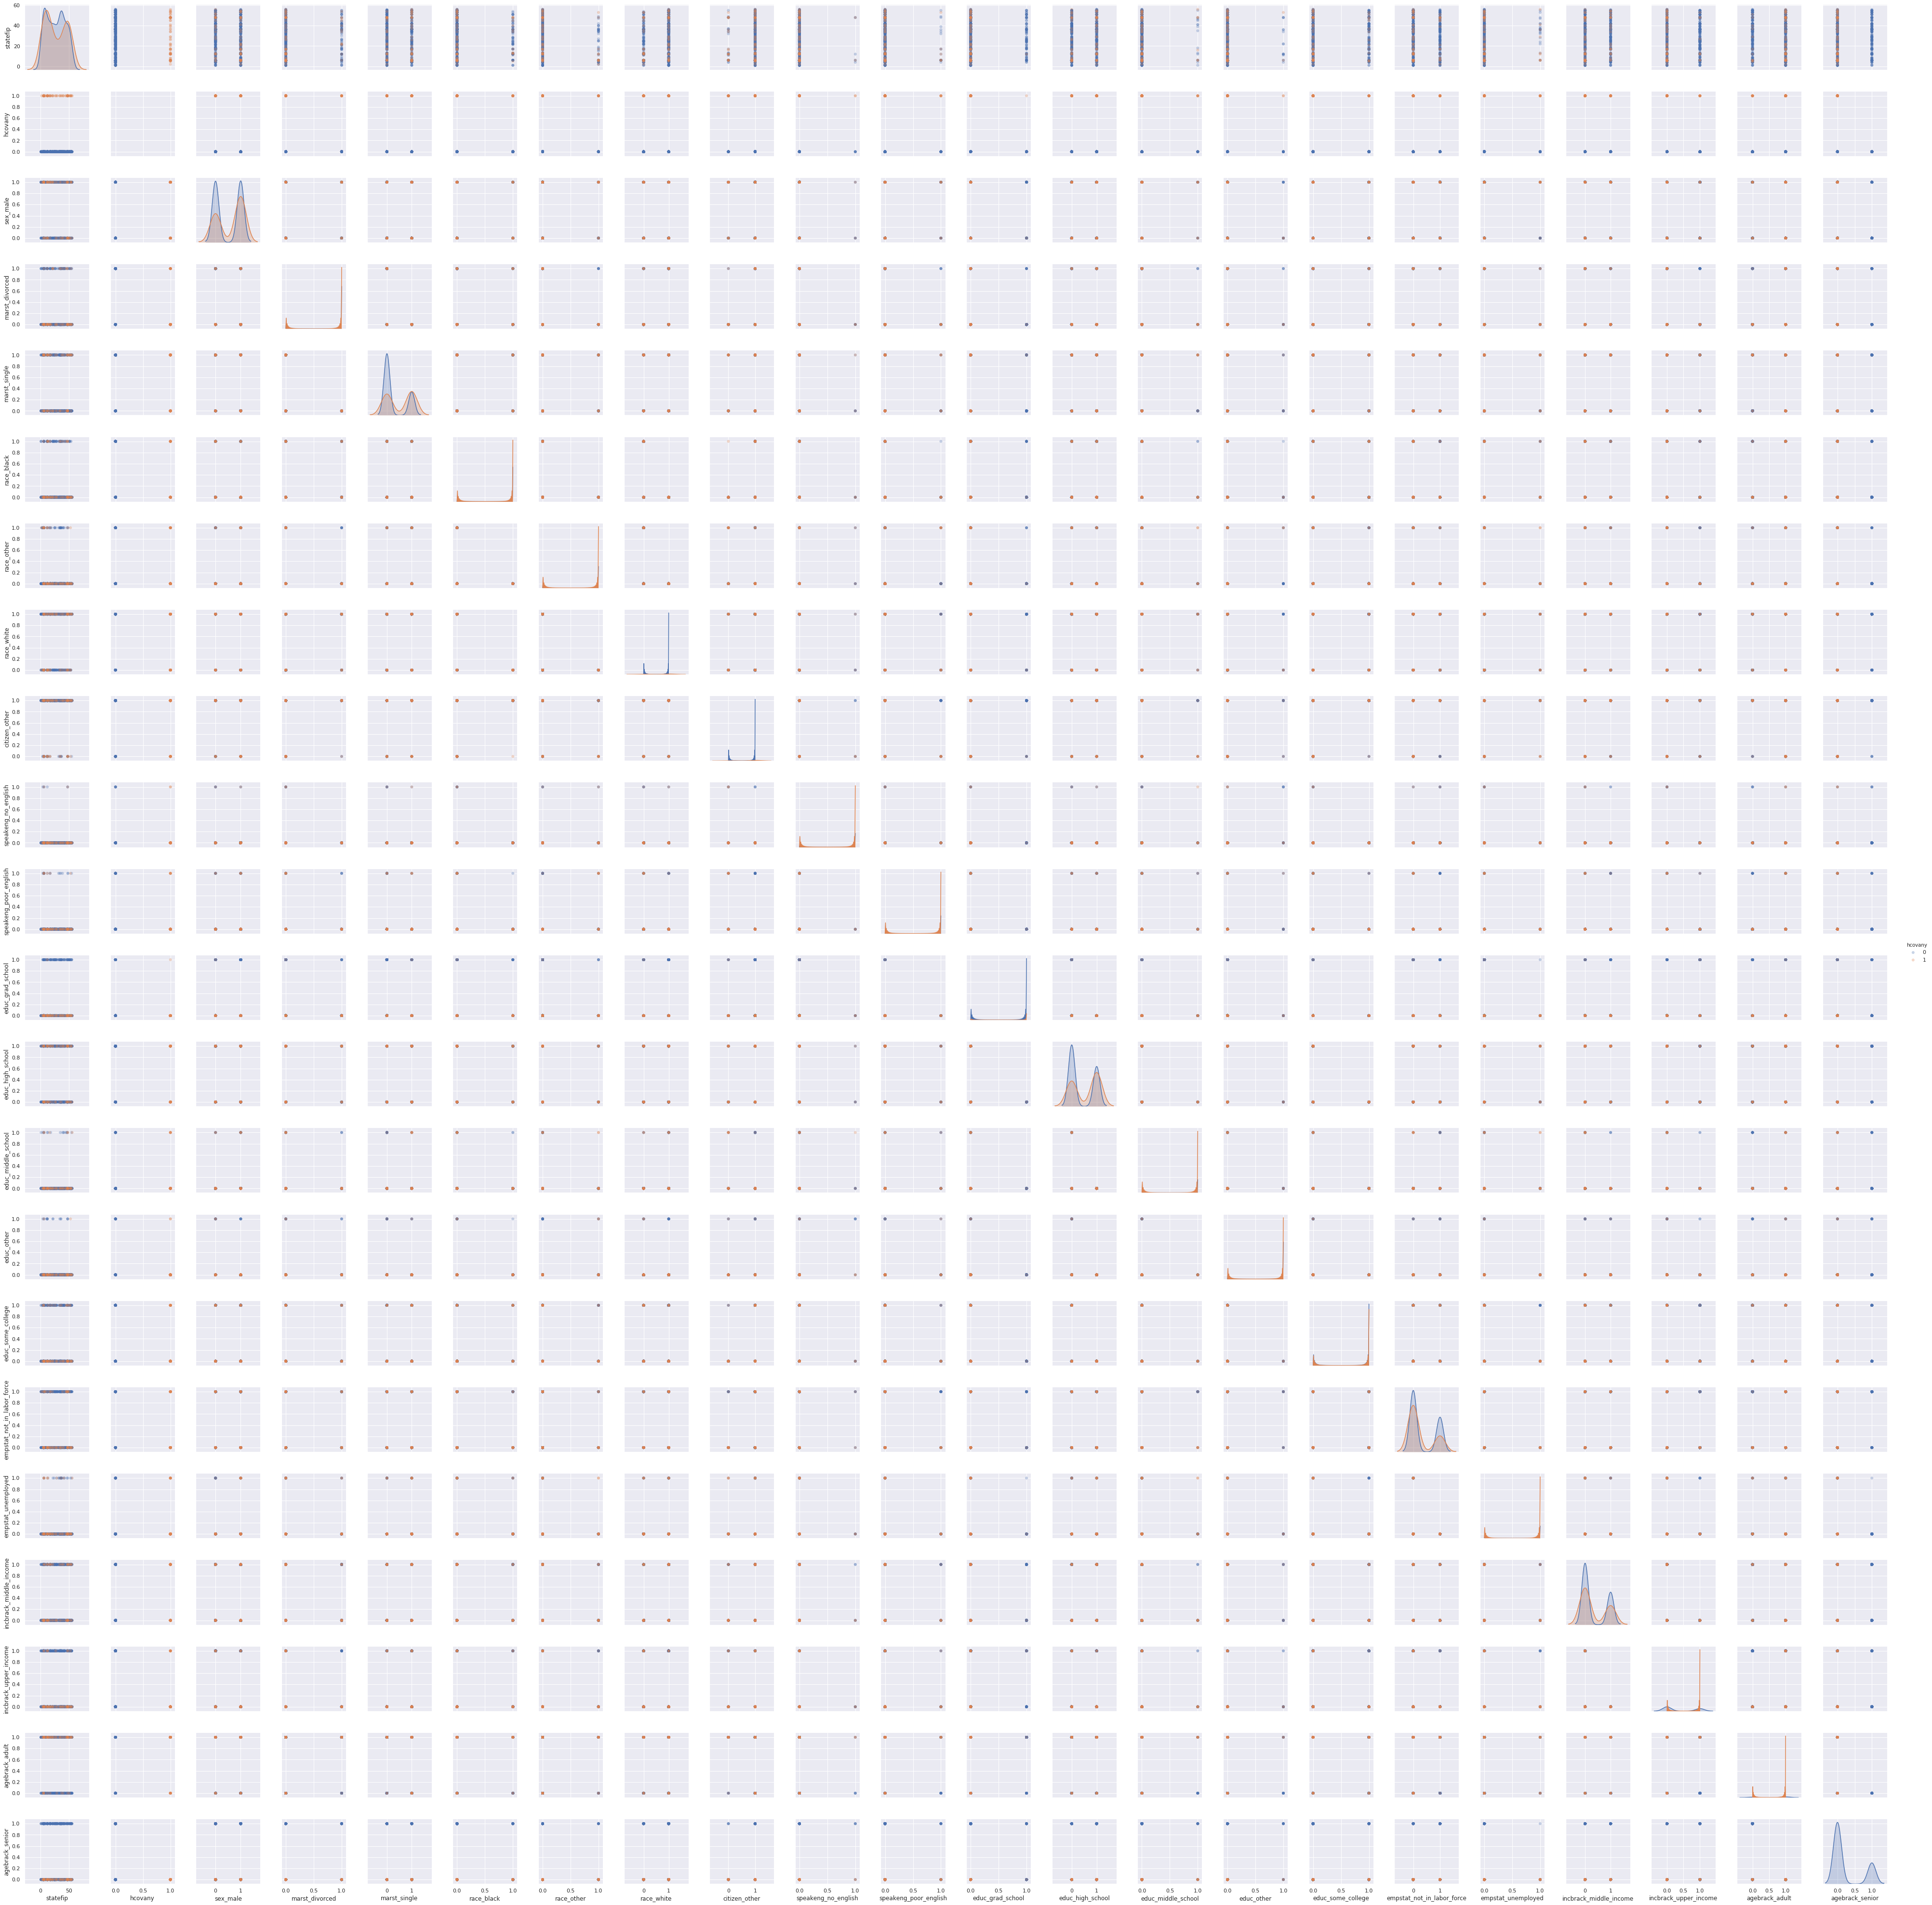

In [45]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['perwt'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='hcovany', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df)

## Model

In [47]:
df.columns

Index(['statefip', 'perwt', 'hcovany', 'sex_male', 'marst_divorced',
       'marst_single', 'race_black', 'race_other', 'race_white',
       'citizen_other', 'speakeng_no_english', 'speakeng_poor_english',
       'educ_grad_school', 'educ_high_school', 'educ_middle_school',
       'educ_other', 'educ_some_college', 'empstat_not_in_labor_force',
       'empstat_unemployed', 'incbrack_middle_income', 'incbrack_upper_income',
       'agebrack_adult', 'agebrack_senior'],
      dtype='object')

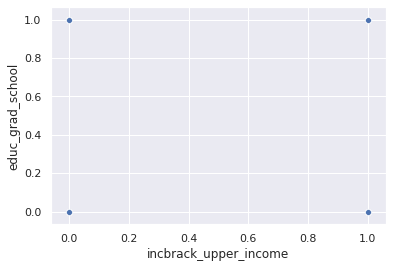

In [48]:
ax = sns.scatterplot(x=df['incbrack_upper_income'], y=df['educ_grad_school'])

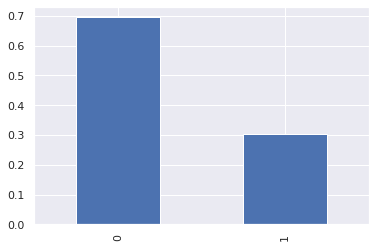

In [51]:
# 1 = single
target_pcts = df['marst_single'].value_counts(normalize=True) 
target_pcts.plot(kind='bar');

In [53]:
# example insurance person: upper_income, grad_school:
formdata = OrderedDict({'sex_male': 1, 'marst_divorced': 0, 'marst_single': 0,
       'race_black': 0, 'race_other': 0, 'race_white': 1, 'citizen_other': 0,
       'speakeng_no_english': 0, 'speakeng_poor_english': 0, 'educ_grad_school': 1,
       'educ_high_school': 0, 'educ_middle_school': 0, 'educ_other': 0,
       'educ_some_college': 0, 'empstat_not_in_labor_force': 0, 'empstat_unemployed': 0,
       'incbrack_middle_income': 0, 'incbrack_upper_income': 1, 'agebrack_adult': 0,
       'agebrack_senior': 0})
X_ins = pd.DataFrame([formdata])

# example insurance person: low_income, poor English, divorced, middle_school education:
formdata = OrderedDict({'sex_male': 1, 'marst_divorced': 1, 'marst_single': 0,
       'race_black': 0, 'race_other': 0, 'race_white': 0, 'citizen_other': 0,
       'speakeng_no_english': 0, 'speakeng_poor_english': 1, 'educ_grad_school': 0,
       'educ_high_school': 0, 'educ_middle_school': 1, 'educ_other': 0,
       'educ_some_college': 0, 'empstat_not_in_labor_force': 0, 'empstat_unemployed': 0,
       'incbrack_middle_income': 0, 'incbrack_upper_income': 0, 'agebrack_adult': 0,
       'agebrack_senior': 0})
X_noins = pd.DataFrame([formdata])

# Models

In [54]:
X = df.drop(['hcovany', 'statefip'], axis=1)
y = df['hcovany']

# X = X.sample(100007)
# y = y.sample(100007)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_weight = X['perwt'].copy()

In [55]:
# Use recall score for model selection since it's important to find all people without health insurance even at the expense of including more people who do have it
def predict_recall(X, y, model):
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    scores_lst = []
    
    X, y = np.array(X), np.array(y)
    
    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind][:,1:], y[train_ind]
        X_val, y_val = X[val_ind][:,1:], y[val_ind]
        X_weight = X_train[:,0] # only include 1st column of array (perwt)
            
        model.fit(X_train, y_train, sample_weight=X_weight)  

#         y_pred = model.predict(X_val)
        #lower threshold slightly to capture more uninsured
        y_pred = (model.predict_proba(X_val)[:, 1] > 0.4)

        scores_lst.append(recall_score(y_val, y_pred))
    
    avg_rec_score = np.mean(scores_lst)
        
    return f'Recall Score: {round(avg_rec_score, 3)}'

### Dummy (Baseline)

In [56]:
dcmodel = DummyClassifier()
predict_recall(X, y, dcmodel)

'Recall Score: 0.089'

### Random Forest

In [57]:
rfmodel = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced')
predict_recall(X, y, rfmodel)

'Recall Score: 0.86'

In [58]:
sorted(zip(X_test.columns, rfmodel.feature_importances_), key=lambda x: -x[1])

[('agebrack_adult', 0.24237850566868455),
 ('incbrack_middle_income', 0.16886938501311347),
 ('race_white', 0.10118904666419867),
 ('marst_divorced', 0.0869078886220208),
 ('educ_grad_school', 0.05971243738860677),
 ('incbrack_upper_income', 0.05296428569841899),
 ('empstat_unemployed', 0.045298219341990485),
 ('educ_some_college', 0.03457819614188307),
 ('speakeng_poor_english', 0.03224158398592447),
 ('empstat_not_in_labor_force', 0.031447551170489946),
 ('educ_high_school', 0.028916523497624625),
 ('race_black', 0.021215060025966365),
 ('sex_male', 0.020709415453023784),
 ('speakeng_no_english', 0.017372078288750006),
 ('race_other', 0.01448470891443488),
 ('educ_other', 0.013306984499018088),
 ('educ_middle_school', 0.012511018585907708),
 ('citizen_other', 0.009449081111330075),
 ('marst_single', 0.00644802992861326),
 ('perwt', 0.0)]

### Logistic Regression with Cross Validation Grid Search

In [59]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(solver="lbfgs", max_iter=1000, class_weight='balanced', n_jobs=-1), param_grid, cv=5)
grid.fit(X.drop('perwt', axis=1), y, sample_weight=X_weight)
optimal_c = grid.best_params_['C']
print(f'Optimal C: {optimal_c}')

lrmodel = LogisticRegression(solver="lbfgs", max_iter=1000, C=optimal_c, class_weight='balanced', n_jobs=-1)
predict_recall(X, y, lrmodel)

Optimal C: 0.01


'Recall Score: 0.887'

In [60]:
sorted(list(zip(lrmodel.coef_[0], X_test.drop('perwt', axis=1))), reverse=True)

[(1.5382792995880352, 'educ_middle_school'),
 (1.1753219464434392, 'educ_other'),
 (0.9332654397042929, 'educ_high_school'),
 (0.9308733297249299, 'empstat_unemployed'),
 (0.9097076658528328, 'speakeng_no_english'),
 (0.7553433979864979, 'marst_single'),
 (0.6087447485951741, 'race_other'),
 (0.5489959590184497, 'marst_divorced'),
 (0.5096981274581197, 'educ_some_college'),
 (0.5017805391852893, 'speakeng_poor_english'),
 (0.32211228032896855, 'race_black'),
 (0.23485304925653633, 'agebrack_adult'),
 (0.1973283136092506, 'race_white'),
 (0.00290130496363651, 'sex_male'),
 (-0.18435618436462908, 'empstat_not_in_labor_force'),
 (-0.37865862571442066, 'educ_grad_school'),
 (-0.5611452974099606, 'incbrack_middle_income'),
 (-1.257803750254649, 'incbrack_upper_income'),
 (-1.2770883869601568, 'citizen_other'),
 (-2.811716302827581, 'agebrack_senior')]

### XGBoost (Oversample)

In [61]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X, y)
X_smoted = pd.DataFrame(X_smoted)
y_smoted = pd.DataFrame(y_smoted)

X_train_smoted, X_test_smoted, y_train_smoted, y_test_smoted = train_test_split(X_smoted, y_smoted, test_size=0.3, random_state=42)
X_weight_smoted = X_train_smoted[1].copy().values.reshape(-1)

In [62]:
xgbmodel_smoted = XGBClassifier(n_jobs=-1)
xgbmodel_smoted.fit(X_train_smoted, y_train_smoted.values.ravel(), sample_weight=X_weight_smoted)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [63]:
y_smote_pred = xgbmodel_smoted.predict(X_test_smoted)
recall_xgb_smote = recall_score(y_test_smoted, y_smote_pred)
recall_xgb_smote

0.7951878010605135

In [76]:
X_test = X_test.drop('perwt', axis=1)
X_test_smoted = X_test_smoted.drop('perwt', axis=1)

In [77]:
fprrf, tprrf, thresholds = roc_curve(y_test, rfmodel.predict_proba(X_test)[:,1])
fprlr, tprlr, thresholds = roc_curve(y_test, lrmodel.predict_proba(X_test)[:,1])
fprxgb, tprxgb, thresholds = roc_curve(y_test_smoted, xgbmodel_smoted.predict_proba(X_test_smoted)[:,1])

W0806 09:03:09.956979 139940789028672 legend.py:1282] No handles with labels found to put in legend.


RF ROC AUC score =  0.8114985346302935


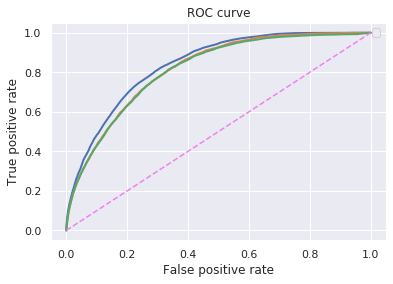

In [82]:
plt.plot(fprxgb, tprxgb,lw=2)
plt.plot(fprlr, tprlr,lw=2)
plt.plot(fprrf, tprrf,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
# plt.legend()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("RF ROC AUC score = ", roc_auc_score(y_test, rfmodel.predict_proba(X_test)[:,1]))
# print("XGB_smoted ROC AUC score = ", roc_auc_score(y_test, xgbmodel_smoted.predict_proba(X_test_smoted)[:,1]))
# print("LR ROC AUC score = ", roc_auc_score(y_test, lrmodel.predict_proba(X_test)[:,1]))

## LR model for each state

In [83]:
query =  "SELECT DISTINCT state_abbr, statefip FROM states"

dfs = pd_sql.read_sql(query, connection)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

for i, row in dfs.iterrows():
    state_abbr_lc = row['state_abbr'].lower()
    statefip = int(row['statefip'])
#     print(state_abbr_lc)

#     pkl_file = 'df_' + state_abbr_lc + '.pkl'
    df = pickle.load(open(f'data/df_{state_abbr_lc}.pkl', "rb"))
    
    X = df.drop(['statefip', 'hcovany'], axis=1)
    y = df['hcovany']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_weight = X_train['perwt'].copy().values.reshape(-1)
    X_train = X_train.drop('perwt', axis=1)                           
    X_test = X_test.drop('perwt', axis=1)
    
    # Find optimal C coefficient using 5-fold cross validation with GridSearchCV
    grid = GridSearchCV(LogisticRegression(solver="lbfgs", max_iter=1000, class_weight='balanced', n_jobs=-1), param_grid, cv=5)
    grid.fit(X_train, y_train, sample_weight=X_weight)
    optimal_c = grid.best_params_['C']

    lr_model = LogisticRegression(solver="lbfgs", C=optimal_c, max_iter=1000, class_weight='balanced', n_jobs=-1)
    lr_model.fit(X_train, y_train, sample_weight=X_weight)
        
    pickle.dump(lr_model, open(f"data/model_{state_abbr_lc}.pkl", "wb"))

In [85]:
lrmodel.predict_proba(X_noins)[0][1]
# health_options[model.predict(X_ins)[0]]

0.9576698250204987

In [87]:
lrmodel.predict_proba(X_ins)[0][1]
# health_options[model.predict(X_ins)[0]]

0.28716623507262956